### Total number of unique words in dataset: 1550
### List of tags: B-val, B-mat, I-electrolyte, B-electrolyte, I-mat, B-morph, I-proc, O, I-val, I-morph, B-proc
### Total Number of tags 11 including O tag

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
from sklearn import metrics
from keras import backend as K
import keras
from  tensorflow.keras.callbacks import TensorBoard
plt.style.use('seaborn')


## As metrices have been removed from Keras from version 2.0, they need to be calculated manually.
## Reference : https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [2]:
# getting the data
file = "../input-datasets/EDLC_ner_dataset_V3.csv"
data = pd.read_csv(file, encoding = "utf-8")

# drop the docId column, it is not needed
data = data.drop('docId', 1)


print(data.head())

words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")

tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")



   SentenceID              Word      Tag
0           1  High-Performance        O
1           1          One-Body  B-morph
2           1        Core/Shell  B-morph
3           1          Nanowire  B-morph
4           1    Supercapacitor        O
Total number of unique words in dataset: 1550
List of tags: B-electrolyte, B-mat, I-val, I-proc, I-morph, B-proc, B-morph, I-mat, I-electrolyte, O, B-val
Total Number of tags 11


[('the', 'O'), ('nanowire', 'B-morph'), ('shell', 'O'), ('is', 'O'), ('composed', 'O'), ('of', 'O'), ('2D', 'B-morph'), ('WS2', 'B-mat'), ('with', 'O'), ('subnanometer', 'O'), ('physical', 'O'), ('gaps', 'O'), ('van', 'O'), ('der', 'O'), ('Waals', 'O'), ('gaps', 'O'), ('in', 'O'), ('between', 'O'), ('individual', 'O'), ('2D', 'B-morph'), ('layers', 'O'), ('for', 'O'), ('facile', 'O'), ('ion', 'O'), ('absorption', 'O'), ('from', 'O'), ('electrolytes', 'O')]


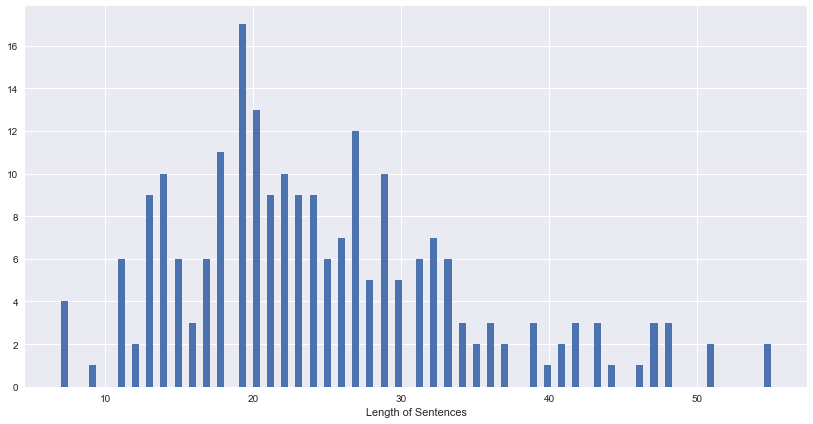

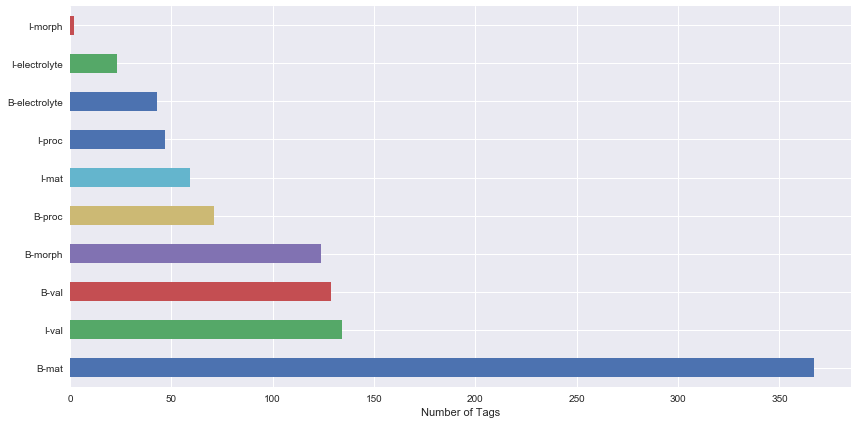

In [3]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("SentenceID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
        
getter = Get_sentence(data)
sentence = getter.sentences
print(sentence[10])

## Exploratory Data Analysis of the loaded dataset

plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 100)
plt.xlabel("Length of Sentences")
plt.show()

plt.figure(figsize=(14, 7))
plt.xlabel("Number of Tags")
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();





In [4]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

print(tag_idx)

max_len = 60
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)


{'B-electrolyte': 0, 'B-mat': 1, 'I-val': 2, 'I-proc': 3, 'I-morph': 4, 'B-proc': 5, 'B-morph': 6, 'I-mat': 7, 'I-electrolyte': 8, 'O': 9, 'B-val': 10}


In [5]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.01)(model)
model = Bidirectional(LSTM(units = 1000,return_sequences = True, recurrent_dropout = 0.01))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)


model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy',precision_m, recall_m, f1_m])

# model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])   ## Main compile phase

model.summary()  ## print model summary

# plot_model(model, show_shapes = True)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 60)            93000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 60)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 2000)          8488000   
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 11)            22011     
Total params: 8,603,011
Trainable params: 8,603,011
Non-trainable params: 0
_________________________________________________________________


In [9]:
# model.fit(x_train, np.array(y_train), batch_size = 16, verbose = 1, epochs = 50, validation_split = 0.2)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

tensorboard_cbk = TensorBoard(log_dir="logs/")

history = model.fit(x_train, np.array(y_train), batch_size = 16, verbose = 1, epochs = 50, validation_split = 0.2,callbacks=[tensorboard_cbk,es])


print("Model Evaluation \n===========================\n")
model.evaluate(x_test, np.array(y_test))

rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentence
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))
    

# y_pred = model.predict(x_test, batch_size=64, verbose=1)
# y_pred_bool = np.argmax(y_pred, axis=1)

# print(metrics.classification_report(y_test,y_pred))


Epoch 1/50
10/10 [==============================] - 3s 342ms/step - loss: 0.0408 - accuracy: 0.9890 - precision_m: 0.9949 - recall_m: 0.9805 - f1_m: 0.9877 - val_loss: 0.2592 - val_accuracy: 0.9642 - val_precision_m: 0.9652 - val_recall_m: 0.9538 - val_f1_m: 0.9595
Epoch 2/50
10/10 [==============================] - 3s 326ms/step - loss: 0.0356 - accuracy: 0.9907 - precision_m: 0.9963 - recall_m: 0.9834 - f1_m: 0.9898 - val_loss: 0.2679 - val_accuracy: 0.9638 - val_precision_m: 0.9638 - val_recall_m: 0.9542 - val_f1_m: 0.9590
Epoch 3/50
10/10 [==============================] - 3s 325ms/step - loss: 0.0356 - accuracy: 0.9891 - precision_m: 0.9957 - recall_m: 0.9836 - f1_m: 0.9896 - val_loss: 0.2727 - val_accuracy: 0.9654 - val_precision_m: 0.9655 - val_recall_m: 0.9545 - val_f1_m: 0.9600
Epoch 4/50
10/10 [==============================] - 3s 327ms/step - loss: 0.0319 - accuracy: 0.9904 - precision_m: 0.9959 - recall_m: 0.9851 - f1_m: 0.9905 - val_loss: 0.2830 - val_accuracy: 0.9629 - va

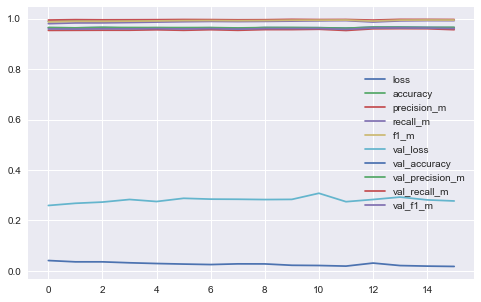

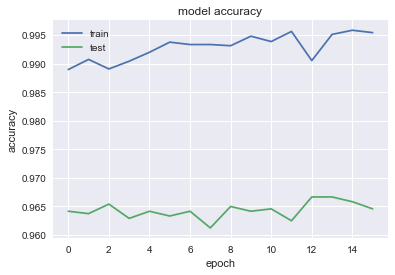

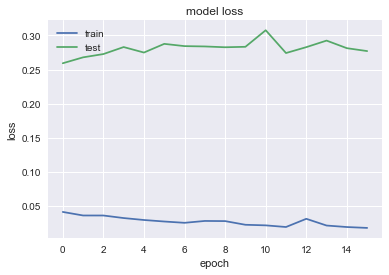

In [10]:
## Plotting all the metrices in a single figure
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



###########################################################################################################
#                                        Saving and loading model                                         #
###########################################################################################################
## Reference : https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model

### As model can not be restored with custom metrices, hence only accuracy and loss is there and compiled the model again
### Then fit the model and save the model

# model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

# model.fit(x_train, np.array(y_train), batch_size = 16, verbose = 1, epochs = 3, validation_split = 0.2)

# model.evaluate(x_test, np.array(y_test))


# ## Save model
# model.save('DeepLearningKerasTf_NER_Model.h5')


###########################################################################################################
#                                        Restoring a Saved model                                          #
###########################################################################################################

## restoring model and checking model
## Currently model restoration feature is off. to load the model just uncomment the following lines and provide saved model name


# new_model = keras.models.load_model('DeepLearningKerasTf_NER_Model.h5')
# print("Loaded Model Evaluation \n===========================\n")
# new_model.evaluate(x_test, np.array(y_test))

In [11]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
        
    p = model.predict(np.array([x_new]))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

test_inputs = "Hierarchical Porous Nitrogen-Doped Carbon Nanosheets Derived from Silk for Ultrahigh-Capacity Battery Anodes and Supercapacitors"
create_test_input_from_text(test_inputs)

test_inputs = "Li metal foil as the counter electrode and 1 M LiPF6 solution with ethylene carbonate-dimethyl carbonate as the electrolyte"
create_test_input_from_text(test_inputs)

Word                	Prediction

-----------------------------------
Hierarchical        	B-mat
Porous              	I-mat
Nitrogen-Doped      	B-mat
Carbon              	B-mat
Nanosheets          	O
Derived             	O
from                	O
Silk                	O
for                 	O
Ultrahigh-Capacity  	O
Battery             	O
Anodes              	O
and                 	O
Supercapacitors     	O
Word                	Prediction

-----------------------------------
Li                  	B-mat
metal               	O
foil                	O
as                  	O
the                 	O
counter             	O
electrode           	O
and                 	O
1                   	B-val
M                   	I-val
LiPF6               	I-val
solution            	O
with                	O
ethylene            	B-electrolyte
carbonate-dimethyl  	I-val
carbonate           	I-electrolyte
as                  	O
the                 	B-val
electrolyte         	B-val
